In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!!pip install pymatgen
# print('done')

['Collecting pymatgen',
 '  Using cached https://files.pythonhosted.org/packages/9b/50/a22eb063ca5ceb27c2be7e51e775ee4b5ade664525be143a2b1b77e4cc70/pymatgen-2021.2.16.tar.gz',
 '  Installing build dependencies ... \x1b[?25l\x1b[?25herror',
 "\x1bERROR: Command errored out with exit status 1: /usr/bin/python3 /usr/local/lib/python3.6/dist-packages/pip install --ignore-installed --no-user --prefix /tmp/pip-build-env-a8pzglsm/overlay --no-warn-script-location -v --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- 'numpy>=1.20.1' 'setuptools>=43.0.0' Check the logs for full command output.\x1b"]

In [ ]:
import os
os.chdir('/content/drive/MyDrive/code/_jupyter-notebooks/calc_feff/v3/NiCl2')

In [ ]:
!chmod +x /content/drive/MyDrive/_others/Colab-stuff/FEFF-on-colab-1/bin/*

In [ ]:
cd ..

/content/drive/My Drive/code/_jupyter-notebooks/calc_feff/v3/NiCl2


In [1]:
import numpy as np
import os,sys
import subprocess as sp 

from pymatgen import MPRester
mpr = MPRester('gI8Qmxe9AnkbTvNd')  # here I put my API key to access MP
from pymatgen.core.periodic_table import Element

import shutil

from numpy import linalg as LA
from scipy.interpolate import InterpolatedUnivariateSpline

from pylab import *
from matplotlib import gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from matplotlib import gridspec

%matplotlib inline

In [2]:
%run -i functions.py

In [3]:
ca='Ni'           # scattering ion symbol

rFMS=8.0          # FMS radius in FEFF calculation
rSCF=6.0          # SCF radius in FEFF calculation
corehole='RPA'    # core-hole treatment

nmax=20           # this will be used to determine inequivalent ions of structure
                  # 50-80 is usually enough.

In [4]:
# or use the one here

sgr_list, formula = get_sgr_list(ca,nmax) 
print(sgr_list, formula)

[(6, 1369), (7, 1348), (8, 1348)] $Cl_{6}Ni_{3}$


In [5]:
sgr_list = [(6, 1348), (7, 1348), (8, 1348)]

In [6]:
n = 0
mm = [n]
cc = [sgr_list[0][1]]
for i,s in enumerate(sgr_list[1:]):
    if s[1] in cc:
        ind = cc.index(s[1])
        mm.append(ind)
    else:
        n = n + 1
        mm.append(n)
        cc.append(s[1])

all_list = []
for i,s in enumerate(sgr_list):
    all_list.append([s[0],mm[i]])

# Put FEFF inputs

In [7]:
%run -i functions.py

def feff_inputs_putter():
    folders_to_calc = []
    done = []
    for i in all_list:    
        if i[1] not in done:    
            f = 'at-'+'{:03d}'.format(i[0]+1)
            os.makedirs(f,exist_ok=True)
            os.chdir(f)
            for_dist_plot, labels_short = write_feffinp(ca=i[0],
                                                        dmax=10,
                                                        rFMS=rFMS,
                                                        rSCF=rSCF,
                                                        corehole=corehole)
            write_xyz(ca=i[0],dmax=10)
            done.append(i[1])
            folders_to_calc.append(os.getcwd())
            os.chdir('..')       
    return folders_to_calc

flist = feff_inputs_putter()
flist

['/data/lt/gd/code/_jupyter-notebooks/calc_feff/v3/NiCl2/at-007']

In [8]:
flist = ['at-007']

# Run FEFF calculations

In [42]:
here = os.getcwd()
for f in flist:
    os.chdir(f)
    print('Doing %s'%(f))
    !/content/drive/MyDrive/_others/Colab-stuff/FEFF-on-colab-1/bin/feff.sh
    os.chdir(here)

Doing at-007
Wed Feb 17 23:11:57 UTC 2021
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
Wed Feb 17 23:27:36 UTC 2021


In [9]:
calculated = []
xmus_calculated = []
atoms_calculated = []
for i in all_list:    
    if i[1] not in calculated:    
        f = 'at-'+'{:03d}'.format(i[0]+1)
        os.chdir(f)
        for_dist_plot, labels_short = write_feffinp(ca=i[0],dmax=10,rFMS=rFMS,rSCF=rSCF,corehole=corehole)
        xmu = np.loadtxt('xmu.dat', unpack=True, comments='#', usecols=(0,3), skiprows=0)
        xmus_calculated.append(xmu)    
        atoms_calculated.append([for_dist_plot, labels_short, i[0]+1])        
        calculated.append(i[1])
        os.chdir('..') 

In [10]:
# calculate occurance of atoms 
la = array(all_list)
la = list(la[:,1])
occ_list = []
for i in calculated:
    occ_list.append(la.count(i))    

        
# find boundaries
e_lowers =[]
e_uppers =[]
for i in xmus_calculated:
    e_lowers.append(i[0][0])
    e_uppers.append(i[0][-1]) 
e_lower = max(e_lowers)
e_upper = min(e_uppers)
e_int = np.arange(e_lower, e_upper, 0.2)  

# interpolate xmus
xmus_calculated_int = []
for i in xmus_calculated:
    f = InterpolatedUnivariateSpline(i[0],i[1])
    i_int = f(e_int)
    xmus_calculated_int.append([e_int,i_int])
    
# weight-averaged total XAS
xmu_total = xmus_calculated_int[0][1]*0
for a,i in enumerate(all_list):
    ind = calculated.index(i[1])
    xmu_total = xmu_total + xmus_calculated_int[ind][1]  
xmu_total = xmu_total/len(all_list)

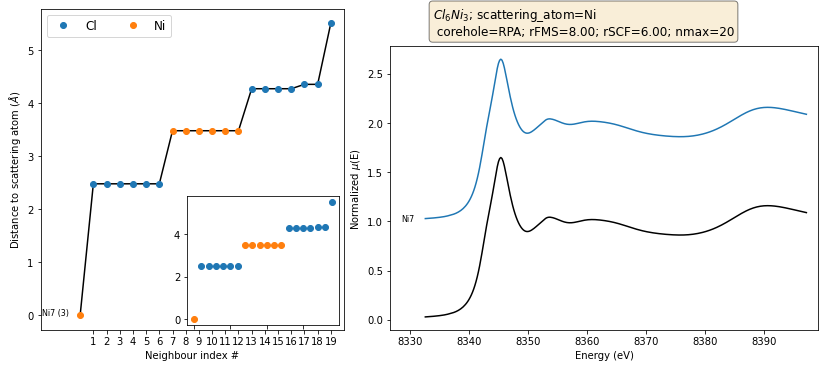

In [11]:
fig = plt.figure(figsize=(12,5+len(atoms_calculated)/4))

gs1 = gridspec.GridSpec(1, 2, width_ratios=[2,3] )
gs1.update(top=0.95, bottom=0.1, left=0.07, right=0.97, wspace=0.05, hspace=0.05)

gs2 = gridspec.GridSpec(1, 2, width_ratios=[2,3] )
gs2.update(top=0.85, bottom=0.1, left=0.02, right=0.97, wspace=0.3, hspace=0.05)


ax=fig.add_subplot(gs1[0])
inset_ax = inset_axes(ax, width="50%", height="40%", loc=4)

s=0
for i in atoms_calculated:   
    ds = np.array(i[0])
    ax.plot(ds[0:20,0]+s,'k-')    
    for i,d in enumerate(ds):
        if i < 20: ax.plot( i, d[0]+s, 'oC'+str(int(d[1])) )   
        if i < 20: inset_ax.plot( i, d[0], 'oC'+str(int(d[1])) )   
    s += 1 
    
plt.xticks(visible=False)
        
for i in atoms_calculated[0][1]:
    ax.plot(19,0,'o',label=i)
    
s = 0          
for i in range(len(atoms_calculated)):
    ax.annotate(ca+str(atoms_calculated[i][2])+' ('+str(occ_list[i])+')',(-2.9,s), fontsize=8)
    s += 1    
    
ax.legend(loc='upper left',fontsize=12,ncol=5) 
ax.set_xticks(range(1,20))

ax.set_xlim([-3,20])  
ax.set_xlabel('Neighbour index #')
ax.set_ylabel('Distance to scattering atom ($\AA$)')    
    

       
ax=fig.add_subplot(gs2[1])
ax.plot(e_int,xmu_total,'k-')
s=1
for i in xmus_calculated_int:
    ax.plot(i[0],s+i[1],'-')
    s = s + 0.4 
    
s = 1          
for i in range(len(atoms_calculated)):
    ax.annotate(ca+str(atoms_calculated[i][2]),(e_int[0]-4,s), fontsize=8)
    s += 0.4     

ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Normalized $\mu$(E)')     
ax.set_xlim([e_int[0]-6,e_int[-1]+2])  

textstr = '%s; scattering_atom=%s \n corehole=%s; rFMS=%.2f; rSCF=%.2f; nmax=%d'%(formula, ca, corehole, rFMS, rSCF, nmax)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)    
ax.text(0.10, 1.14, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
    
savefig('feff.png', format='png', dpi=300)    

In [12]:
folders = [f for f in os.listdir() if os.path.isdir(f)]
os.makedirs('feff',exist_ok=True)
for f in folders:
    if f[0:3] == 'at-': shutil.move(f, 'feff')
    
np.save('./feff/_xmus_calculated', xmus_calculated)    
np.save('./feff/_xmus_calculated_int', xmus_calculated_int)      
np.save('./feff/_atoms_calculated', atoms_calculated) 
np.save('./feff/_e_int', e_int) 
np.save('./feff/_xmu_total', xmu_total) 
np.save('./feff/_all_list', all_list) 

shutil.make_archive('feff', 'zip', 'feff')
# shutil.move('feff.zip', 'feff.npz')

shutil.rmtree('feff', ignore_errors=True)